In [1]:
import numpy as np
import matplotlib.pyplot as plt
import qutip as qt
from scipy.optimize import curve_fit
import datetime

$$H_R = \frac{i\eta\Omega}{2}\left(\sigma_+a+\sigma_-a^\dagger\right)$$
$$H_B = \frac{i\eta\Omega}{2}\left(\sigma_-a+\sigma_+a^\dagger\right)$$

$$\left|0\right>\otimes\left|\overline{n}\right>$$

$$\frac{P_{R, e}(t)}{P_{B, e}(t)-P_{R, e}(t)}$$

$$\overline{n}\approx 5$$

## Read the file

In [15]:
def readFile(filename):
    timeTickFirst, timeTickLast, x, ion1, ion1_raw, ion1_bottom, ion1_top, ion2, ion2_raw, ion2_bottom, ion2_top\
      = np.loadtxt(filename, comments='#', delimiter='\t', converters=None, 
                   skiprows=0,unpack=True, encoding='latin1')
    return x, ion1, ion2

In [16]:
xb, BSB1, BSB2 = readFile('ms_blue_time_scan_rfsoc_001')
plt.plot(xb, BSB1, '.')

## Define Hamiltonian

In [4]:
times = xb
nMax = 20

In [51]:
def H(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times, delta = 0):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))\
            +delta/2*qt.tensor(qt.sigmaz(), qt.qeye(nMax))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))\
            +delta/2*qt.tensor(qt.sigmaz(), qt.qeye(nMax))
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.thermal_dm(nMax, n))

    c_ops = [qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
             qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    e_ops = qt.tensor(qt.sigmax(), qt.qeye(nMax))
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result.expect[0]

### Test the Hamiltonian

In [55]:
H0 = []
H1 = []
n0 = 0.0
etaOmega = 0.055
delta = 0.1*etaOmega
count = 0
for t in xb:
    H0.append(H(n0, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
    H1.append(H(n0, False, 0, etaOmega, [0,t], delta = delta)[-1]) # Test Blue sideband
    
plt.plot(xb,H0)
plt.plot(xb,H1)
plt.ylim([0,1])

(0, 1)

In [34]:
def H2(n, isRed = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times):
    H_R = etaOmega/2*(qt.tensor(qt.sigmap(), qt.destroy(nMax))+qt.tensor(qt.sigmam(), qt.create(nMax)))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.ket2dm(qt.coherent(nMax, n)))
    psi_1 = qt.tensor(qt.ket2dm(qt.basis(2, 0)), qt.ket2dm(qt.coherent(nMax, n)))

    c_ops = [
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
                 qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
    if isRed == True:
        result = qt.mesolve(H_R, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    else:
        result = qt.mesolve(H_B, psi_0, times, c_ops, qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax)))
    
    return result

H0 = []
n0 = 1
etaOmega = 0.05
count = 0
times = np.linspace(0,500,2001)
results = H2(n0, False, 0, etaOmega, times)# Test Blue sideband
    
plt.plot(times,results.expect[0])
plt.ylim([0,1])

(0, 1)

## Curve fit

In [11]:
def Red(x, n0, etaOmega):
    return H(n0, True, 0, etaOmega, x)
def Blue(x, n0, etaOmega):
    return H(n0, False, 0, etaOmega, x)

def FitRed(xdata, ydata, guess):
    popt, pcov = curve_fit(Red, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/100)+0.005)
    plt.plot(xdata, Red(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])
    
def FitBlue(xdata, ydata, guess):
    popt, pcov = curve_fit(Blue, xdata, ydata, guess, sigma=np.sqrt(ydata*(1-ydata)/100)+0.005, absolute_sigma = False)
    plt.plot(xdata, Blue(xdata, *popt), 'r-',
         label='fit: n0=%5.3f, etaOmega=%5.3f' % tuple(popt))
    plt.errorbar(xdata, ydata, yerr=np.sqrt(ydata*(1-ydata)/100)+0.005 ,ls='',marker='o')
    plt.legend()
    plt.xlabel('Time (us)')
    plt.ylabel('Population')
    plt.show()
    print(popt)
    print(np.sqrt(np.diag(pcov)[0]))
    return popt, np.sqrt(np.diag(pcov)[0])

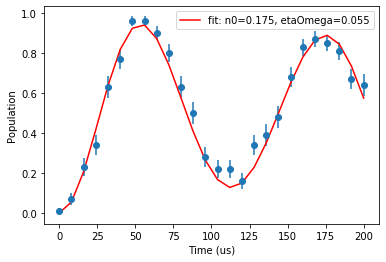

[0.17476632 0.05472814]
0.02762841913177359


In [12]:
### Test fit: BSB
xdata = xb
ydata = BSB1
guess = np.array([0.2, 0.04])
BSB_fit = FitBlue(xdata, ydata, guess)

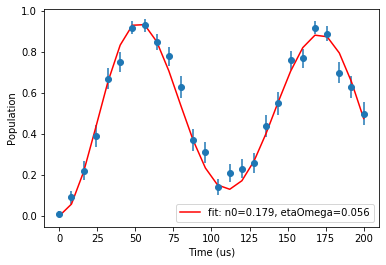

[0.17859941 0.05593544]
0.02624420027884998


In [17]:
xb, BSB1, BSB2 = readFile('ms_blue_time_scan_rfsoc_002')
xdata = xb
ydata = BSB1
guess = np.array([0.2, 0.04])
BSB_fit = FitBlue(xdata, ydata, guess)

(0, 1)

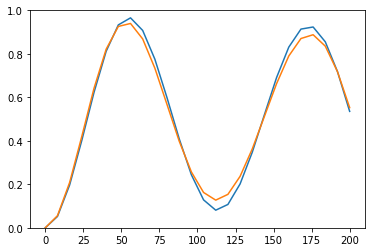

In [67]:
H0 = []
H1 = []
n0 = 0.175
etaOmega = 0.055
count = 0
for t in xb:
    H0.append(H(0.1, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
    H1.append(H(n0, False, 0, etaOmega, [0,t])[-1]) # Test Blue sideband
    
plt.plot(xb,H0)
plt.plot(xb,H1)
plt.ylim([0,1])

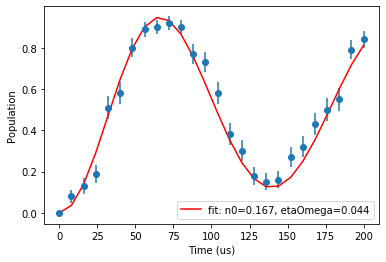

[0.1673647  0.04438838]
0.029812815415218


In [18]:
xb, BSB1, BSB2 = readFile('ms_blue_time_scan_rfsoc_indv2_001')
xdata = xb
ydata = BSB2
guess = np.array([0.2, 0.04])
BSB_fit = FitBlue(xdata, ydata, guess)

In [19]:
xb, BSB1, BSB2 = readFile('ms_blue_time_scan_rfsoc_indv2_002')
xdata = xb
ydata = BSB2
guess = np.array([0.2, 0.04])
BSB_fit = FitBlue(xdata, ydata, guess)

[0.22870168 0.0447454 ]
0.040266719999533615


In [110]:
def H_kick(n, isMS = True, Gamma = 0, etaOmega = 5*2*np.pi, times = times, delta_r = 0, delta_b = 0):
    H_R_1 = etaOmega/2*qt.tensor(qt.sigmap(), qt.destroy(nMax))       
    H_R_2 = etaOmega/2*qt.tensor(qt.sigmam(), qt.create(nMax))
    H_B = etaOmega/2*(qt.tensor(qt.sigmam(), qt.destroy(nMax))+qt.tensor(qt.sigmap(), qt.create(nMax)))
    def H_R1_coeff(t, args):
        delta = 1*2*np.pi
        return np.exp(1j*delta_r*t)
    def H_R2_coeff(t, args):
        delta = 1*2*np.pi
        return np.exp(-1j*delta_r*t)
    
#     psi_0 = qt.tensor(qt.ket2dm((qt.basis(2, 1)+qt.basis(2, 0))/np.sqrt(2)), qt.thermal_dm(nMax, n))
    psi_0 = qt.tensor(qt.ket2dm(qt.basis(2, 1)), qt.thermal_dm(nMax, n))
    
    c_ops = [qt.tensor(qt.qeye(2), np.sqrt(Gamma*(n+1))*qt.destroy(nMax)),          # Heating
             qt.tensor(qt.qeye(2), np.sqrt(Gamma*n)*qt.create(nMax))]
    
#     e_ops = qt.tensor(qt.sigmay(), qt.qeye(nMax))
    e_ops = qt.tensor((qt.qeye(2)+qt.sigmaz())/2, qt.qeye(nMax))
    if isMS:
        H = [H_B,[H_R_1, H_R1_coeff],[H_R_2, H_R2_coeff]]
    else:
        H = H_B
    result = qt.mesolve(H, psi_0, times, c_ops, e_ops)
    
    return result.expect[0]

(-0.05, 1.05)

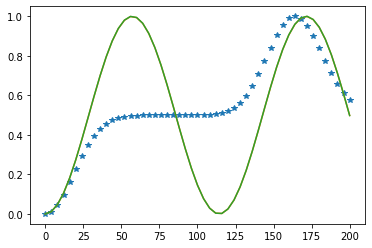

In [111]:
H0 = []
H1 = []
n0 = 0.0
etaOmega = 0.055 #MHz
delta = 0.3*2*np.pi #MHz

times = np.linspace(0, 200, 51)

H0 = (H_kick(n0, True, 0, etaOmega, times)) # Two tone no red detuning
H1 = (H_kick(n0, True, 0, etaOmega, times, delta_r = delta, delta_b = 0)) # Two tone with red detuning
H2 = (H_kick(n0, False, 0, etaOmega, times, delta_r = delta, delta_b = 0)) # Test Blue sideband
    
plt.plot(times,H0,'*')
plt.plot(times,H1)
plt.plot(times,H2)
plt.ylim([-0.05,1.05])

In [84]:
H0

[]